In [62]:
import os
import sys
sys.path.insert(0, os.path.abspath(".."))
from models import UNetDiffusion, UNet_diffusion_normal
import torch
from models import Diffusion
import matplotlib.pyplot as plt
import numpy as np
from data import PDE1D, WeatherBench
from torch.distributions.lowrank_multivariate_normal import LowRankMultivariateNormal
from torch.distributions.multivariate_normal import MultivariateNormal
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import scienceplots

import cmcrameri
from cmap import Colormap
plt.rcParams['image.cmap']= "viridis"
cmap = Colormap('seaborn:icefire').to_mpl()
cmap2 = cmap#Colormap('crameri:lajolla_r').to_mpl()
device = "cuda"

# Adjust diffusion process to get EU

In [63]:
def reshape_to_x_sample(parameter, x):
    return parameter.view(*parameter.shape, *(1,) * (x.ndim - parameter.ndim)).expand(
        x.shape
    )


class DistributionalDiffusion(Diffusion):
    def __init__(
        self,
        noise_steps=1000,
        noise_schedule="linear",
        img_size=256,
        device="cuda",
        distributional_method="normal",
        closed_form=False,
        x_T_sampling_method="standard",
        ddim_churn=1.0,
        beta_endpoints=(1e-4, 0.02),
        tau = 1,
        **kwargs,
    ):
        super().__init__(
            noise_steps=noise_steps,
            noise_schedule=noise_schedule,
            img_size=img_size,
            device=device,
            x_T_sampling_method=x_T_sampling_method,
            ddim_churn=ddim_churn,
            beta_endpoints=beta_endpoints,
            tau = tau,
        )
        self.distributional_method = distributional_method
        self.closed_form = closed_form
        self.tau = tau

   
    def sample_noise(self, model, x, t, conditioning=None, pred=None):
        if self.distributional_method == "normal":
            predicted_noise = model(x, t, conditioning, pred=pred)
            # Calculate epistemic uncertainty
            var = predicted_noise[..., 1]
            eu = var.squeeze()

            predicted_noise = predicted_noise[..., 0] + np.sqrt(self.tau) * predicted_noise[
                ..., 1
            ] * torch.randn_like(predicted_noise[..., 0], device=self.device)   

        elif self.distributional_method == "mvnormal":
            predicted_noise = model(x, t, conditioning, pred=pred)
            if predicted_noise.shape[-1] == predicted_noise.shape[-2] + 1:
                # Cholesky
                mu = predicted_noise[..., 0]
                L_full = np.sqrt(self.tau) * predicted_noise[..., 1:]
                mvnorm = MultivariateNormal(loc=mu, scale_tril=L_full)
            else:  # Lora
                mu = predicted_noise[..., 0]
                diag = self.tau * predicted_noise[..., 1]
                lora = np.sqrt(self.tau) * predicted_noise[..., 2:]
                mvnorm = LowRankMultivariateNormal(mu, lora, diag)
            predicted_noise = mvnorm.sample()

        elif self.distributional_method == "sample":
            predicted_noise = model(x, t, conditioning, pred=pred, n_samples=1).squeeze(
                -1
            )
        elif self.distributional_method == "mixednormal":
            predicted_mixture = model(x, t, conditioning, pred=pred)
            mu = predicted_mixture[..., 0]
            sigma = np.sqrt(self.tau) * predicted_mixture[..., 1]
            weights = predicted_mixture[..., 2]
            sampled_weights = torch.distributions.Categorical(weights).sample()
            sampled_mu = torch.gather(mu, dim=-1, index=sampled_weights.unsqueeze(-1))
            sampled_sigma = torch.gather(
                sigma, dim=-1, index=sampled_weights.unsqueeze(-1)
            )
            predicted_noise = sampled_mu + sampled_sigma * torch.randn_like(
                sampled_mu, device=self.device
            )
            predicted_noise = predicted_noise.squeeze(-1)
        return predicted_noise, eu

    def sample_low_dimensional(
        self, model, n, conditioning=None, cfg_scale=3, pred=None, gt_target=None
    ):
        model.eval()
        eu_array = torch.zeros(n, *self.img_size[1:],self.noise_steps)
        with torch.no_grad():
            x = self.sample_x_T((n, *self.img_size), pred, inference=True)
            for i in reversed(range(1, self.noise_steps)):
                t = (torch.ones(n) * i).long().to(self.device)
                if self.closed_form and self.distributional_method in [
                    "normal",
                    "mixednormal",
                    "mvnormal",
                ]:
                    predicted_noise_distribution_params = model(
                        x, t, conditioning, pred=pred
                    )
                    x = self.sample_x_t_closed_form(
                        x,
                        t,
                        predicted_noise_distribution_params,
                        pred,
                        i,
                        method=self.distributional_method,
                    )
                else:
                    predicted_noise, eu = self.sample_noise(model, x, t, conditioning, pred)
                    alpha = reshape_to_x_sample(self.alpha[t], x).squeeze()
                    alpha_hat = reshape_to_x_sample(self.alpha_hat[t], x).squeeze()
                    eu_array[...,i] = (1-alpha)**2 / (alpha * (1-alpha_hat)) * eu
                    if cfg_scale > 0:
                        uncond_predicted_noise = self.sample_noise(
                            model, x, t, None, pred
                        )
                        predicted_noise = torch.lerp(
                            uncond_predicted_noise, predicted_noise, cfg_scale
                        )
                    x = self.sample_x_t_inference_DDIM(x, t, predicted_noise, pred, i)

        model.train()
        return x, eu_array.squeeze()


def generate_diffusion_samples_low_dimensional(
    model,
    input,
    n_timesteps,
    target_shape,
    n_samples,
    x_T_sampling_method,
    distributional_method="deterministic",
    closed_form=False,
    regressor=None,
    cfg_scale=3,
    gt_target=None,
    ddim_churn=1.0,
    noise_schedule=None,
    metrics_plots=False,
    beta_endpoints=(1e-4, 0.02),
    tau = 1,
):
    if distributional_method == "deterministic":
        diffusion = Diffusion(
            noise_steps=n_timesteps,
            img_size=target_shape[1:],
            device=input.device,
            x_T_sampling_method=x_T_sampling_method,
            ddim_churn=ddim_churn,
            noise_schedule=noise_schedule,
            beta_endpoints=beta_endpoints,
            tau = tau,
        )
    else:
        diffusion = DistributionalDiffusion(
            noise_steps=n_timesteps,
            img_size=target_shape[1:],
            device=input.device,
            distributional_method=distributional_method,
            closed_form=closed_form,
            x_T_sampling_method=x_T_sampling_method,
            ddim_churn=ddim_churn,
            noise_schedule=noise_schedule,
            beta_endpoints=beta_endpoints,
            tau = tau,
        )

    sampled_images = torch.zeros(*target_shape, n_samples).to(input.device)
    eu_array = torch.zeros(input.shape[0], *input.shape[2:], n_timesteps, n_samples).to(input.device)
    for i in range(n_samples):
        with torch.no_grad():
            pred, eu = diffusion.sample_low_dimensional(
                model,
                n=input.shape[0],
                conditioning=input,
                pred=None,
                cfg_scale=cfg_scale,
            )
            sampled_images[..., i] = pred.detach()
            eu_array[...,i] = eu.detach()
    return sampled_images, eu_array

# KS

In [64]:
test_dataset = PDE1D(
    data_dir="../data/",
    pde="KS",
    var="test",
    downscaling_factor=1,
    normalize=True,
    last_t_steps=2,
    temporal_downscaling_factor=2,
    select_timesteps="zero"
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=2,
    shuffle=True,
    num_workers=0,
)

target_dim, input_dim = (
    (1, *test_dataset.get_dimensions()),
    (3, *test_dataset.get_dimensions()),
)
grid = test_dataset.get_coordinates()[0]

In [65]:
cfg_scale = 0
x_T_sampling_method="standard"
n_timesteps = 50
n_samples = 50
t_steps = 50

In [66]:
n_test = len(test_dataset)
indices = np.random.choice(n_test, 3, replace=False)
indices = np.array([357, 211, 833])
input = []
target = []
trajectory = []
for idx in indices:
    target_tensor, input_tensor = test_dataset.get_trajectory(idx, length = n_timesteps)
    target_tensor = target_tensor.unsqueeze(0).to(device)
    input_tensor = input_tensor.unsqueeze(0).to(device)
    input.append(input_tensor)
    target.append(target_tensor[:,:,2]-input_tensor[:,-2])
    trajectory.append(target_tensor)
input = torch.cat(input, dim=0)
target = torch.cat(target, dim=0)
trajectory = torch.cat(trajectory, dim=0)

## Normal

In [67]:
ckpt_path = "../results/KS/normal/Datetime_20250831_102648_Loss_1D_KS_UNet_diffusion_normal_T50_DDIM1.pt"
distributional_method = "normal"
beta_endpoints = (0.001, 0.2)

In [68]:
backbone =  UNetDiffusion(
            d=1,
            conditioning_dim=3,
            hidden_channels=64,
            in_channels=1,
            out_channels=1,
            init_features=64,
            domain_dim = target_dim
        )

model = UNet_diffusion_normal(
    backbone=backbone,
    d=1,
    target_dim = 1,
)
model.load_state_dict(
    torch.load(ckpt_path, map_location=device)
)
model = model.to(device)


/tmp/ipykernel_231227/467673265.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(ckpt_path, map_location=device)


In [69]:
pred, eu = generate_diffusion_samples_low_dimensional(
    model=model,
    input = input,
    n_timesteps=n_timesteps,
    target_shape=target.shape,
    n_samples=n_samples,
    distributional_method=distributional_method,
    x_T_sampling_method=x_T_sampling_method,
    cfg_scale=cfg_scale,
    noise_schedule="linear",
    beta_endpoints = beta_endpoints,
)

In [70]:
grid_input = input[:,2:3,:]
t0 = input[:,1:2,:]
full_array = torch.zeros(input.shape[0], 1, input.shape[2], t_steps,n_samples, device=device)
eu_array = torch.zeros(input.shape[0],input.shape[2], n_timesteps, n_samples,t_steps)

for i in range(n_samples):
    autoregressive_input = input.clone()
    pred_array = torch.zeros(input.shape[0], 1, input.shape[2], t_steps, device=device)
    for t in range(t_steps):
        pred, eu = generate_diffusion_samples_low_dimensional(
            model=model,
            input = autoregressive_input,
            n_timesteps=n_timesteps,
            target_shape=target.shape,
            n_samples=1,
            distributional_method=distributional_method,
            x_T_sampling_method=x_T_sampling_method,
            cfg_scale=cfg_scale,
            noise_schedule="linear",
            beta_endpoints = beta_endpoints,
        )
        eu_array[...,i,t] = eu.squeeze()
        if t == 0:
            pred_array[...,t] = pred.squeeze(-1)+ t0
        else:
            pred_array[...,t] = pred.squeeze(-1) + pred_array[...,t-1]

        if t == 1:
            autoregressive_input = torch.cat([t0, pred_array[...,0], grid_input], dim = 1)
        elif t > 1:
            autoregressive_input = torch.cat([pred_array[...,t-1],pred_array[...,t], grid_input], dim = 1)
    # Save
    full_array[...,i] = pred_array

In [71]:
ticksize = 33
legendsize = 36
axissize = 35
titlesize = 40
plt.style.use(["science"])

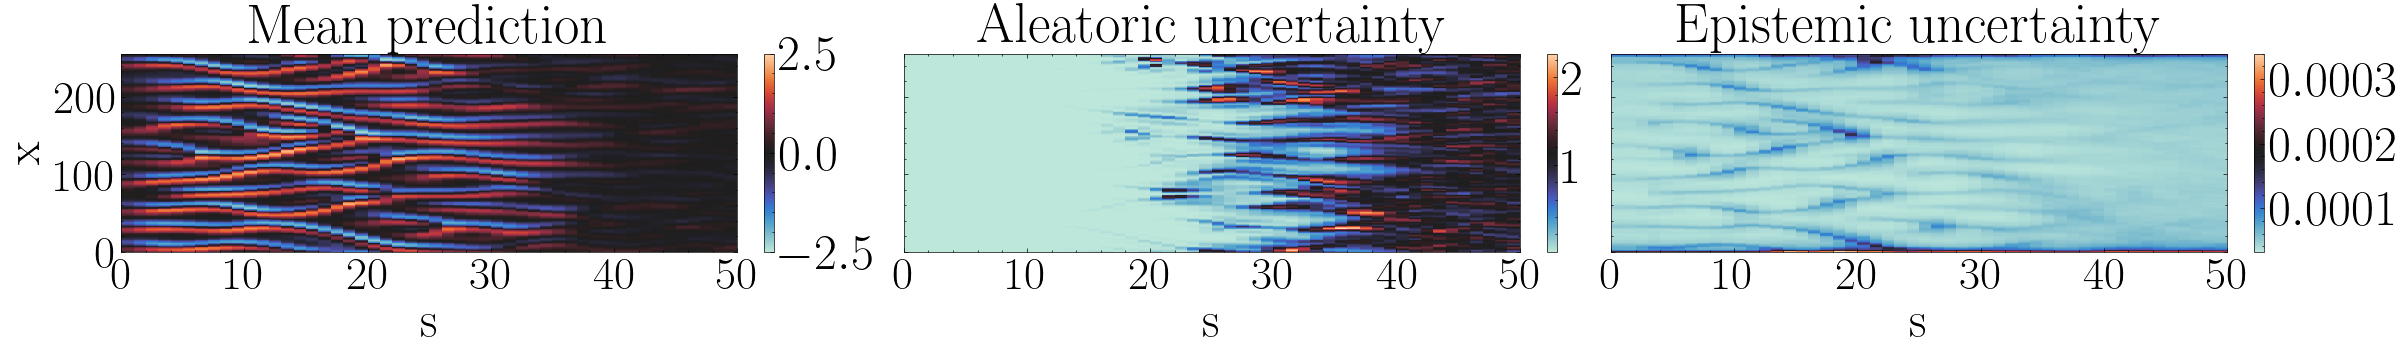

In [72]:
b = 2
vmin_truth = -2.5
vmax_truth = 2.5

fig, axs = plt.subplots(1, 3, figsize = (24,3.5), sharey = True, layout = "constrained")
axs = axs.ravel()
cbs = []

im2 = axs[0].pcolormesh(full_array[b,0].mean(dim = -1).cpu(), cmap = cmap, rasterized = True, vmin = vmin_truth, vmax = vmax_truth)
axs[0].set_title("Mean prediction", fontsize = titlesize)
cb1 = fig.colorbar(im2, ax = axs[0], pad = 0.01)
cbs.append(cb1)

im3 = axs[1].pcolormesh(full_array[b,0].var(axis = -1).cpu(), cmap = cmap2, rasterized = True)
axs[1].set_title("Aleatoric uncertainty", fontsize = titlesize)
cb1 = fig.colorbar(im3, ax = axs[1], pad = 0.01)
cbs.append(cb1)

im4 = axs[2].pcolormesh(eu_array[b].mean(dim = (1,2)).cpu(), cmap = cmap2,  rasterized = True)
axs[2].set_title("Epistemic uncertainty", fontsize = titlesize)
cb1 = fig.colorbar(im4, ax = axs[2], pad = 0.01)
cbs.append(cb1)



axs[0].yaxis.set_major_locator(plt.MaxNLocator(3))
axs[0].set_ylabel("x", fontsize = axissize)

for ax in axs:
    ax.set_xlabel("s", fontsize = axissize) 
    ax.xaxis.set_major_locator(plt.MaxNLocator(5))



for ax in axs:
    ax.tick_params(axis="both", which="major", labelsize=ticksize)

for cb in cbs:
    cb.ax.tick_params(labelsize=legendsize)


plt.savefig("plots/KS_eu_small.pdf", bbox_inches = "tight")

In [73]:
ticksize = 29
legendsize = 32
axissize = 31
titlesize = 36
plt.style.use(["science"])

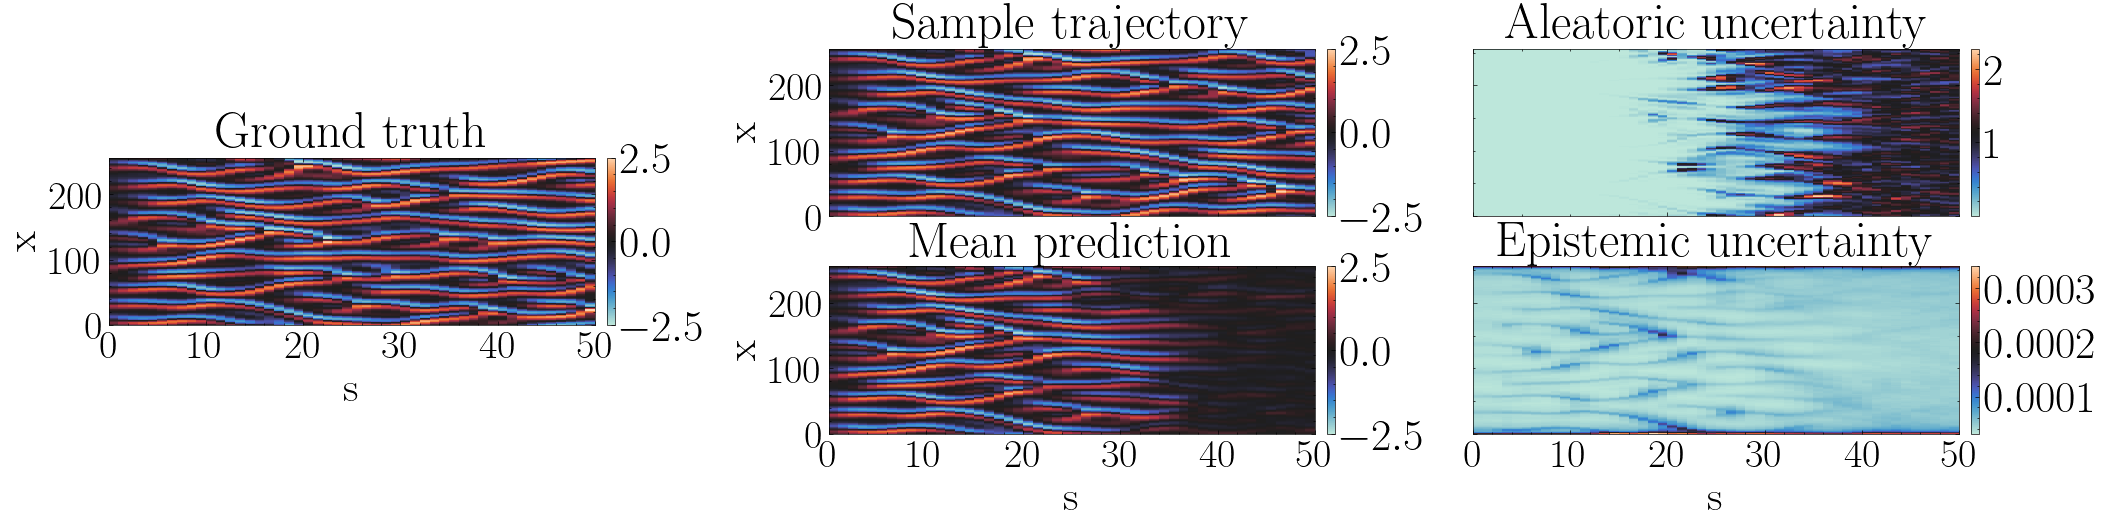

In [74]:
b = 2

fig = plt.figure(figsize=(25, 5))

# Outer grid: 2 rows × 2 columns
outer = gridspec.GridSpec(2, 2, figure=fig, width_ratios=[1, 2], wspace=0.1, hspace=0.15)

# Right block: a 2×2 inside the right column
right_gs = gridspec.GridSpecFromSubplotSpec(
    2, 2, subplot_spec=outer[:, 1], wspace=0.1, hspace=0.3
)

axs = [
    fig.add_subplot(right_gs[0, 0]),
    fig.add_subplot(right_gs[0, 1]),
    fig.add_subplot(right_gs[1, 0]),
    fig.add_subplot(right_gs[1, 1]),
]

cbs = []

# Left subplot: put in the middle between top and bottom
# → we compute its size from one right subplot and align manually
pos_top = axs[0].get_position()
pos_bottom = axs[2].get_position()

# Same height as one of the right plots
height = pos_top.height
# Same vertical center as the 2×2 block
center_y = (pos_top.y0 + pos_bottom.y1) / 2

# Manually add left axis with matching size
ax_left = fig.add_axes([0.12, center_y - height/2, pos_top.width, height])

# --- Plots ---
vmin_truth = -2.5
vmax_truth = 2.5
im1 = axs[0].pcolormesh(full_array[b,0,...,0].cpu(), cmap=cmap, rasterized = True, vmin = vmin_truth, vmax = vmax_truth)
axs[0].set_title("Sample trajectory", fontsize = titlesize)
cbs.append(fig.colorbar(im1, ax=axs[0], pad = 0.02))

im3 = axs[1].pcolormesh(full_array[b,0].var(axis=-1).cpu(), cmap=cmap2, rasterized = True)
axs[1].set_title("Aleatoric uncertainty", fontsize = titlesize)
cbs.append(fig.colorbar(im3, ax=axs[1], pad = 0.02))

im2 = axs[2].pcolormesh(full_array[b,0].mean(dim=-1).cpu(), cmap=cmap, rasterized = True, vmin = vmin_truth, vmax = vmax_truth)
axs[2].set_title("Mean prediction", fontsize = titlesize)
cbs.append(fig.colorbar(im2, ax=axs[2], pad = 0.02))

im4 = axs[3].pcolormesh(eu_array[b].mean(dim=(1,2)).cpu(), cmap=cmap2, rasterized = True)
axs[3].set_title("Epistemic uncertainty", fontsize = titlesize)
cbs.append(fig.colorbar(im4, ax=axs[3], pad = 0.02))

# Left plot
im_left = ax_left.pcolormesh(trajectory[b,0,2:].t().cpu(), cmap=cmap, rasterized = True, vmin = vmin_truth, vmax = vmax_truth)
ax_left.set_title("Ground truth", fontsize = titlesize)
cbs.append(fig.colorbar(im_left, ax=ax_left, pad = 0.02))

# Add labels
# Hide x-ticks on the top row
for ax in [axs[0], axs[1]]:
    ax.set_xticklabels([])
    ax.set_xlabel("")

# Hide y-ticks on the right column
for ax in [axs[1], axs[3]]:
    ax.set_yticklabels([])
    ax.set_ylabel("")

for ax in [ax_left] + [axs[0], axs[2]]:
    ax.yaxis.set_major_locator(plt.MaxNLocator(3))

for ax in [ax_left] + [axs[2], axs[3]]:
    ax.xaxis.set_major_locator(plt.MaxNLocator(5))

# Add labels only where needed
axs[2].set_xlabel("s", fontsize = axissize)   # bottom left
axs[3].set_xlabel("s", fontsize = axissize)   # bottom right
axs[0].set_ylabel("x", fontsize = axissize)   # top left
axs[2].set_ylabel("x", fontsize = axissize)   # bottom left

# Do the same for the left (truth) plot
ax_left.set_xlabel("s", fontsize = axissize)
ax_left.set_ylabel("x", fontsize = axissize)

for ax in [ax_left] + axs:
    ax.tick_params(axis="both", which="major", labelsize=ticksize)

for cb in cbs:
    cb.ax.tick_params(labelsize=legendsize)

plt.savefig("plots/KS_eu.pdf", bbox_inches = "tight")

# Burgers

In [75]:
test_dataset = PDE1D(
    data_dir="../data/",
    pde="Burgers",
    var="test",
    downscaling_factor=4,
    normalize=True,
    last_t_steps=2,
    temporal_downscaling_factor=2,
    select_timesteps="zero"
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=2,
    shuffle=True,
    num_workers=0,
)

target_dim, input_dim = (
    (1, *test_dataset.get_dimensions()),
    (3, *test_dataset.get_dimensions()),
)
grid = test_dataset.get_coordinates()[0]

In [ ]:
cfg_scale = 0
x_T_sampling_method="standard"
n_timesteps = 50
n_samples = 50
t_steps = 50

In [77]:
n_test = len(test_dataset)
indices = np.random.choice(n_test, 3, replace=False)
indices = np.array([357, 211, 833])
input = []
target = []
trajectory = []
for idx in indices:
    target_tensor, input_tensor = test_dataset.get_trajectory(idx, length = n_timesteps)
    target_tensor = target_tensor.unsqueeze(0).to(device)
    input_tensor = input_tensor.unsqueeze(0).to(device)
    input.append(input_tensor)
    target.append(target_tensor[:,:,2]-input_tensor[:,-2])
    trajectory.append(target_tensor)
input = torch.cat(input, dim=0)
target = torch.cat(target, dim=0)
trajectory = torch.cat(trajectory, dim=0)

## Normal

In [78]:
ckpt_path = "../results/Burgers/normal/Datetime_20250829_011108_Loss_1D_Burgers_UNet_diffusion_normal_T50_DDIM1.pt"
distributional_method = "normal"
beta_endpoints = (0.001, 0.2)

In [79]:
backbone =  UNetDiffusion(
            d=1,
            conditioning_dim=3,
            hidden_channels=64,
            in_channels=1,
            out_channels=1,
            init_features=64,
            domain_dim = target_dim
        )

model = UNet_diffusion_normal(
    backbone=backbone,
    d=1,
    target_dim = 1,
)
model.load_state_dict(
    torch.load(ckpt_path, map_location=device)
)
model = model.to(device)


/tmp/ipykernel_231227/467673265.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(ckpt_path, map_location=device)


In [80]:
pred, eu = generate_diffusion_samples_low_dimensional(
    model=model,
    input = input,
    n_timesteps=n_timesteps,
    target_shape=target.shape,
    n_samples=n_samples,
    distributional_method=distributional_method,
    x_T_sampling_method=x_T_sampling_method,
    cfg_scale=cfg_scale,
    noise_schedule="linear",
    beta_endpoints = beta_endpoints,
)

In [81]:
grid_input = input[:,2:3,:]
t0 = input[:,1:2,:]
full_array = torch.zeros(input.shape[0], 1, input.shape[2], t_steps,n_samples, device=device)
eu_array = torch.zeros(input.shape[0],input.shape[2], n_timesteps, n_samples,t_steps)

for i in range(n_samples):
    autoregressive_input = input.clone()
    pred_array = torch.zeros(input.shape[0], 1, input.shape[2], t_steps, device=device)
    for t in range(t_steps):
        pred, eu = generate_diffusion_samples_low_dimensional(
            model=model,
            input = autoregressive_input,
            n_timesteps=n_timesteps,
            target_shape=target.shape,
            n_samples=1,
            distributional_method=distributional_method,
            x_T_sampling_method=x_T_sampling_method,
            cfg_scale=cfg_scale,
            noise_schedule="linear",
            beta_endpoints = beta_endpoints,
        )
        eu_array[...,i,t] = eu.squeeze()
        if t == 0:
            pred_array[...,t] = pred.squeeze(-1)+ t0
        else:
            pred_array[...,t] = pred.squeeze(-1) + pred_array[...,t-1]

        if t == 1:
            autoregressive_input = torch.cat([t0, pred_array[...,0], grid_input], dim = 1)
        elif t > 1:
            autoregressive_input = torch.cat([pred_array[...,t-1],pred_array[...,t], grid_input], dim = 1)
    # Save
    full_array[...,i] = pred_array

In [82]:
full_array.shape, trajectory.shape, eu_array.shape

(torch.Size([3, 1, 256, 50, 25]),
 torch.Size([3, 1, 52, 256]),
 torch.Size([3, 256, 50, 25, 50]))

In [83]:
ticksize = 31
legendsize = 34
axissize = 33
titlesize = 38
plt.style.use(["science"])

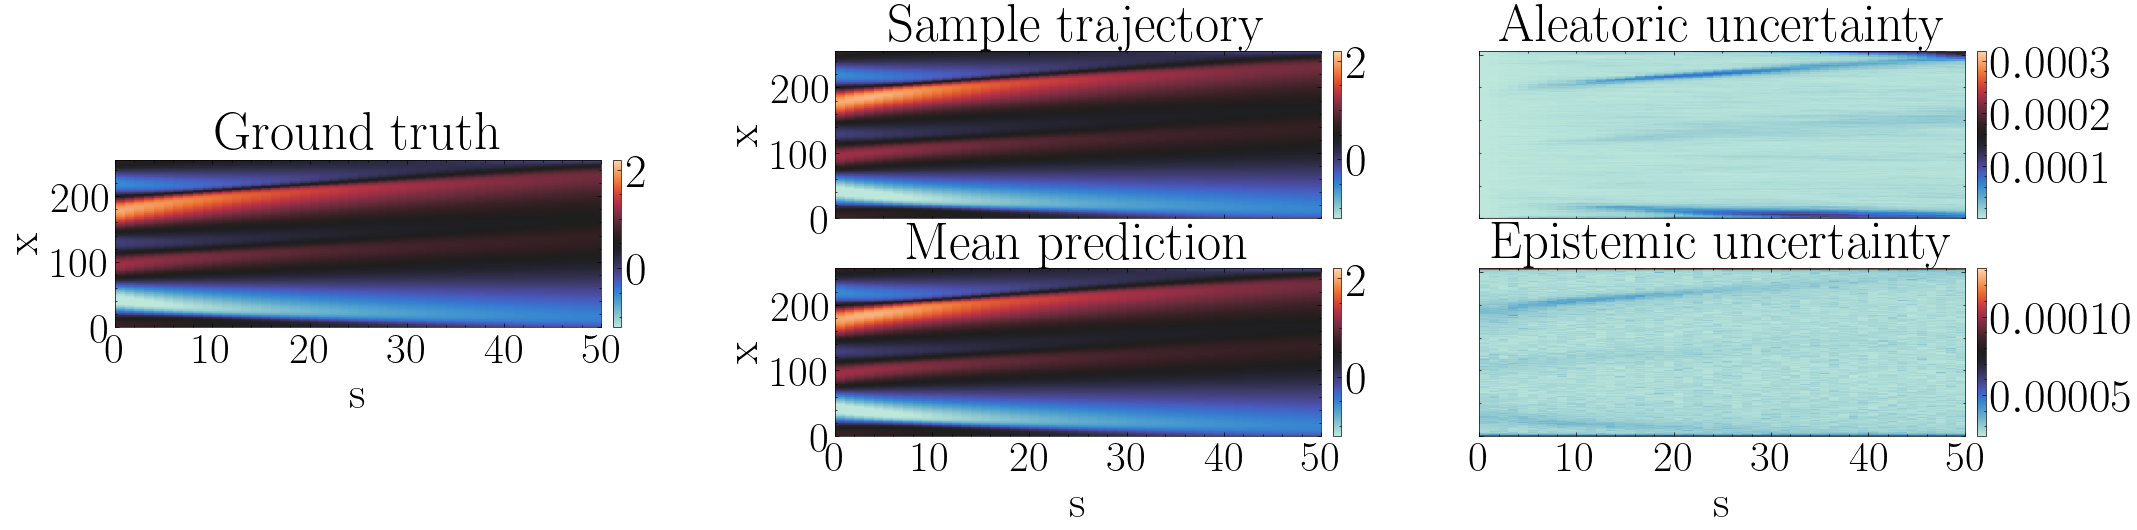

In [84]:
b = 2

fig = plt.figure(figsize=(25, 5))

# Outer grid: 2 rows × 2 columns
outer = gridspec.GridSpec(2, 2, figure=fig, width_ratios=[1, 2], wspace=0.1, hspace=0.15)

# Right block: a 2×2 inside the right column
right_gs = gridspec.GridSpecFromSubplotSpec(
    2, 2, subplot_spec=outer[:, 1], wspace=0.1, hspace=0.3
)

axs = [
    fig.add_subplot(right_gs[0, 0]),
    fig.add_subplot(right_gs[0, 1]),
    fig.add_subplot(right_gs[1, 0]),
    fig.add_subplot(right_gs[1, 1]),
]

cbs = []

# Left subplot: put in the middle between top and bottom
# → we compute its size from one right subplot and align manually
pos_top = axs[0].get_position()
pos_bottom = axs[2].get_position()

# Same height as one of the right plots
height = pos_top.height
# Same vertical center as the 2×2 block
center_y = (pos_top.y0 + pos_bottom.y1) / 2

# Manually add left axis with matching size
ax_left = fig.add_axes([0.12, center_y - height/2, pos_top.width, height])

# --- Plots ---
vmin_truth = -1.2
vmax_truth = 2.2
im1 = axs[0].pcolormesh(full_array[b,0,...,0].cpu(), cmap=cmap, rasterized = True, vmin = vmin_truth, vmax = vmax_truth)
axs[0].set_title("Sample trajectory", fontsize = titlesize)
cbs.append(fig.colorbar(im1, ax=axs[0], pad = 0.02))

im3 = axs[1].pcolormesh(full_array[b,0].var(axis=-1).cpu(), cmap=cmap2, rasterized = True)
axs[1].set_title("Aleatoric uncertainty", fontsize = titlesize)
cbs.append(fig.colorbar(im3, ax=axs[1], pad = 0.02))

im2 = axs[2].pcolormesh(full_array[b,0].mean(dim=-1).cpu(), cmap=cmap, rasterized = True, vmin = vmin_truth, vmax = vmax_truth)
axs[2].set_title("Mean prediction", fontsize = titlesize)
cbs.append(fig.colorbar(im2, ax=axs[2], pad = 0.02))

im4 = axs[3].pcolormesh(eu_array[b].mean(dim=(1,2)).cpu(), cmap=cmap2, rasterized = True)
axs[3].set_title("Epistemic uncertainty", fontsize = titlesize)
cbs.append(fig.colorbar(im4, ax=axs[3], pad = 0.02))

# Left plot
im_left = ax_left.pcolormesh(trajectory[b,0,2:].t().cpu(), cmap=cmap, rasterized = True, vmin = vmin_truth, vmax = vmax_truth)
ax_left.set_title("Ground truth", fontsize = titlesize)
cbs.append(fig.colorbar(im_left, ax=ax_left, pad = 0.02))

# Add labels
# Hide x-ticks on the top row
for ax in [axs[0], axs[1]]:
    ax.set_xticklabels([])
    ax.set_xlabel("")

# Hide y-ticks on the right column
for ax in [axs[1], axs[3]]:
    ax.set_yticklabels([])
    ax.set_ylabel("")

for ax in [ax_left] + [axs[0], axs[2]]:
    ax.yaxis.set_major_locator(plt.MaxNLocator(3))

for ax in [ax_left] + [axs[2], axs[3]]:
    ax.xaxis.set_major_locator(plt.MaxNLocator(5))

# Add labels only where needed
axs[2].set_xlabel("s", fontsize = axissize)   # bottom left
axs[3].set_xlabel("s", fontsize = axissize)   # bottom right
axs[0].set_ylabel("x", fontsize = axissize)   # top left
axs[2].set_ylabel("x", fontsize = axissize)   # bottom left

# Do the same for the left (truth) plot
ax_left.set_xlabel("s", fontsize = axissize)
ax_left.set_ylabel("x", fontsize = axissize)

for ax in [ax_left] + axs:
    ax.tick_params(axis="both", which="major", labelsize=ticksize)

for cb in cbs:
    cb.ax.tick_params(labelsize=legendsize)

plt.savefig("plots/Burgers_eu.pdf", bbox_inches = "tight")

# WeatherBench

In [85]:
test_dataset = WeatherBench(
    var="test",
    downscaling_factor=1,
    normalize=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=3,
    shuffle=False,
    num_workers=0,
)

target_dim, input_dim = (
    (1, *test_dataset.get_dimensions()),
    (3, *test_dataset.get_dimensions()),
)
lat_lon, t= test_dataset.get_grid()
lat,lon = lat_lon

# Index of input t2m
t2m = 1
ll,t = test_dataset.get_grid()
lat, lon = ll

In [86]:
cfg_scale = 0
x_T_sampling_method="standard"
n_timesteps = 50
n_samples = 50

In [87]:
idx = 5
target, input = test_dataset[idx]
target = target.unsqueeze(0).to(device)
input = input.unsqueeze(0).to(device)

In [88]:
ckpt_path = "../results/T2M/normal/Datetime_20250908_031720_Loss_WeatherBench_UNet_diffusion_normal_T50_DDIM1.pt"
distributional_method = "normal"
beta_endpoints = (0.001, 0.2)

In [89]:
backbone =  UNetDiffusion(
            d=2,
            conditioning_dim=12,
            hidden_channels=64,
            in_channels=1,
            out_channels=1,
            init_features=64,
            domain_dim = target_dim
        )

model = UNet_diffusion_normal(
    backbone=backbone,
    d=2,
    target_dim = 1,
)
model.load_state_dict(
    torch.load(ckpt_path, map_location=device)
)
model = model.to(device)


/tmp/ipykernel_231227/682118688.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(ckpt_path, map_location=device)


In [90]:
pred, eu = generate_diffusion_samples_low_dimensional(
    model=model,
    input = input,
    n_timesteps=n_timesteps,
    target_shape=target.shape,
    n_samples=n_samples,
    distributional_method=distributional_method,
    x_T_sampling_method=x_T_sampling_method,
    cfg_scale=cfg_scale,
    noise_schedule="linear",
    beta_endpoints=beta_endpoints
)

input_last_t = input[:,t2m].cpu()
pred = pred.cpu().squeeze() + input_last_t.unsqueeze(-1)
pred = test_dataset.destandardize_output(pred) - 273.15
target = target.cpu().squeeze() + input_last_t
target = test_dataset.destandardize_output(target) - 273.15

# Plot

In [91]:
ticksize = 18
legendsize = 21
axissize = 20
titlesize = 22
plt.style.use(["science"])

b = 0

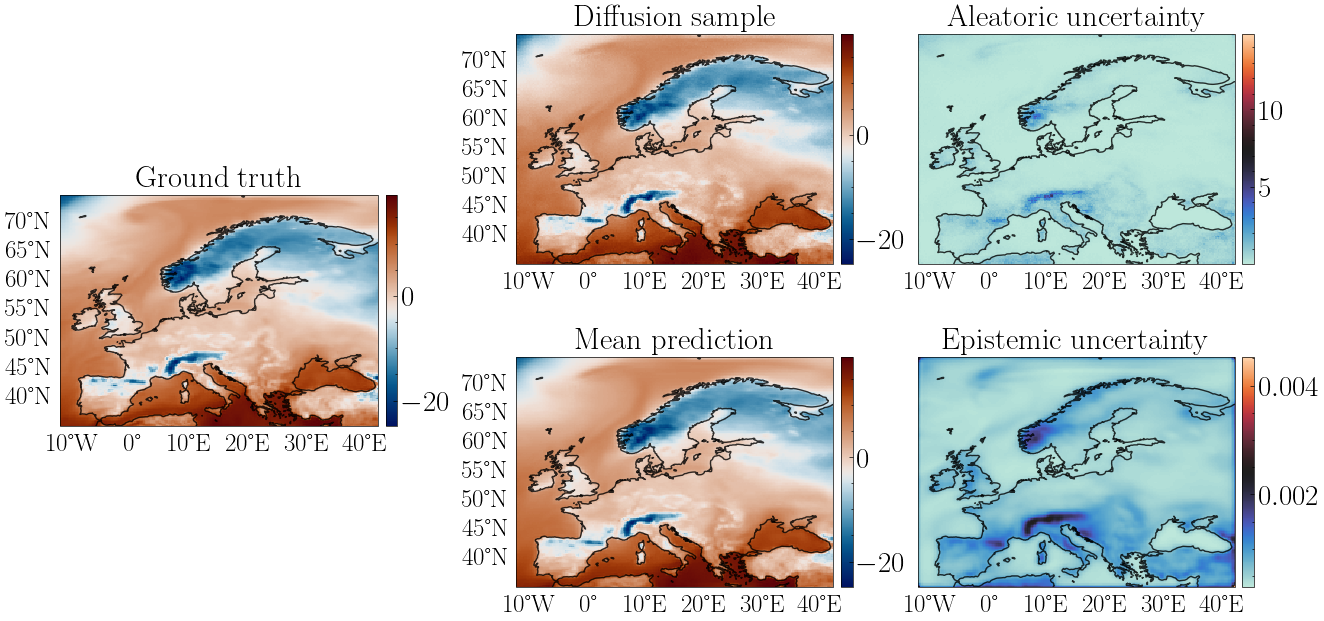

In [92]:
vmin_truth = target[b].min()
vmax_truth = target[b].max()
s=0

error_cmap = Colormap('seaborn:icefire').to_mpl()

fig = plt.figure(figsize=(16, 8))

# Make a 2×3 grid: left col has one subplot spanning both rows,
# right 2×2 block are normal subplots
outer = gridspec.GridSpec(2, 3, figure=fig, width_ratios=[1, 0.85, 1],
                            wspace=0.2, hspace=0.1)


# Right block: 2×2 grid inside columns 1–2
right_gs = gridspec.GridSpecFromSubplotSpec(
    2, 2, subplot_spec=outer[:, 1:], wspace=0.05, hspace=0.1
)

axs = [
    fig.add_subplot(right_gs[0, 0], projection=ccrs.PlateCarree()),
    fig.add_subplot(right_gs[0, 1], projection=ccrs.PlateCarree()),
    fig.add_subplot(right_gs[1, 0], projection=ccrs.PlateCarree()),
    fig.add_subplot(right_gs[1, 1], projection=ccrs.PlateCarree()),
]

# Left panel: put it in the left column spanning both rows
ax_left = fig.add_subplot(outer[:, 0], projection=ccrs.PlateCarree())

# Now adjust its position to match the height of one right-hand subplot,
# and center it vertically.
ref_top = axs[0].get_position()     # top-right subplot
ref_bottom = axs[2].get_position()  # bottom-right subplot
ref_height = ref_top.height
ref_center_y = (ref_top.y0 + ref_bottom.y1) / 2

# Keep the left subplot's width, but reset its vertical placement
pos = ax_left.get_position()
ax_left.set_position([pos.x0, ref_center_y - ref_height/2,
                    pos.width, ref_height])

cbs = []

# --- Plots ---
im_left = ax_left.pcolormesh(lon, lat, target[b], shading="nearest",
                                rasterized=True, vmin=vmin_truth, vmax=vmax_truth, cmap="cmc.vik")
ax_left.set_title("Ground truth", fontsize=titlesize)
cbs.append(fig.colorbar(im_left, ax=ax_left, shrink=0.375, pad = 0.02))

im1 = axs[0].pcolormesh(lon, lat, pred[b, ..., s].numpy(), shading="nearest",
                        rasterized=True, vmin=vmin_truth, vmax=vmax_truth, cmap="cmc.vik")
axs[0].set_title("Diffusion sample", size=titlesize)
cbs.append(fig.colorbar(im1, ax=axs[0], shrink=0.783, pad = 0.02))

im2 = axs[1].pcolormesh(lon, lat, pred[b,...,].var(dim = -1).numpy(), shading = "nearest", cmap = cmap, rasterized = True)
axs[1].set_title("Aleatoric uncertainty", size=titlesize)
cbs.append(fig.colorbar(im2, ax=axs[1], shrink=0.783, pad = 0.02))

im3 = axs[2].pcolormesh(lon, lat, pred[b].mean(dim=-1).numpy(), shading="nearest",
                        rasterized=True, vmin=vmin_truth, vmax=vmax_truth, cmap="cmc.vik")
axs[2].set_title("Mean prediction", size=titlesize)
cbs.append(fig.colorbar(im3, ax=axs[2], shrink=0.783, pad = 0.02))

im3 = axs[3].pcolormesh(lon, lat, eu[b].mean(dim = (-2,-1)).cpu().numpy(),shading = "nearest", cmap = cmap, rasterized = True)
axs[3].set_title("Epistemic uncertainty", size=titlesize)
cbs.append(fig.colorbar(im3, ax=axs[3], shrink=0.783, pad = 0.02))

for ax in axs + [ax_left]:
    ax.set_extent([lon[0]-360, lon[-1], lat[0], lat[-1]], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, alpha = 0.8)

for ax in axs + [ax_left]:
    gl = ax.gridlines(draw_labels={"bottom":"x"}, dms=True, x_inline=False, y_inline=False)
    gl.xlines = False
    gl.ylines = False
    gl.xlabel_style = {'size':ticksize}

for ax in [ax_left, axs[0], axs[2]]:
    gl = ax.gridlines(draw_labels={"left":"y"}, dms=True, x_inline=False, y_inline=False)
    gl.xlines = False
    gl.ylines = False
    gl.ylabel_style = {'size':ticksize}


for cb in cbs:
    cb.ax.tick_params(labelsize=legendsize)



plt.savefig("plots/T2M_eu.pdf", bbox_inches = "tight")

# Workshop plot

In [93]:
ticksize = 20
legendsize = 23
axissize = 22
titlesize = 28
plt.style.use(["science"])

b = 0

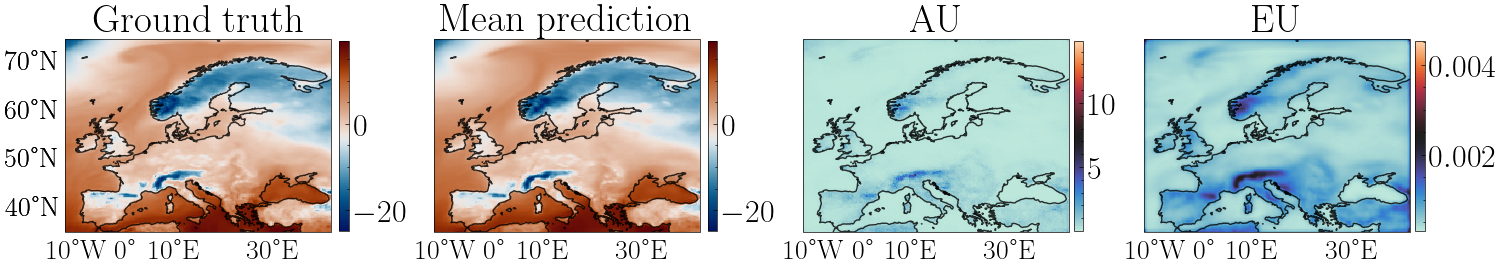

In [94]:

fig, axs = plt.subplots(1, 4, figsize=(15, 4), sharex=True, sharey=True, subplot_kw={'projection': ccrs.PlateCarree()}, layout = "constrained")
pred = pred.squeeze(1).cpu()
target = target.squeeze(1).cpu()
error_cmap = Colormap('seaborn:icefire').to_mpl()

vmin_truth = target[b].min()
vmax_truth =target[b].max()

cbs = []
shrink = 0.485
# Truth Residual
im1 = axs[0].pcolormesh(lon, lat, target[b], shading = "nearest", rasterized = True, vmin = vmin_truth, vmax = vmax_truth, cmap = "cmc.vik")
cbs.append(fig.colorbar(im1, ax=axs[0], pad = 0.03, shrink = shrink))
axs[0].set_title("Ground truth", size = titlesize)

im2 = axs[1].pcolormesh(lon, lat, pred[b].mean(dim=-1).numpy(), shading="nearest", rasterized=True, vmin=vmin_truth, vmax=vmax_truth, cmap="cmc.vik")
axs[1].set_title("Mean prediction", size=titlesize)
cbs.append(fig.colorbar(im2, ax=axs[1], shrink=shrink, pad = 0.03))

im3 = axs[2].pcolormesh(lon, lat, pred[b,...,].var(dim = -1).numpy(), shading = "nearest", cmap = cmap, rasterized = True)
axs[2].set_title("AU", size=titlesize)
cbs.append(fig.colorbar(im3, ax=axs[2], shrink=shrink, pad = 0.02))

im4 = axs[3].pcolormesh(lon, lat, eu[b].mean(dim = (-2,-1)).cpu().numpy(),shading = "nearest", cmap = cmap, rasterized = True)
axs[3].set_title("EU", size=titlesize)
cbs.append(fig.colorbar(im4, ax=axs[3], shrink=shrink, pad = 0.02))

for ax in axs:
    ax.set_extent([lon[0]-360, lon[-1], lat[0], lat[-1]], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, alpha = 0.8)

for i in range(4):
    gl = axs[i].gridlines(draw_labels={"bottom":"x"}, dms=True, x_inline=False, y_inline=False)
    gl.xlines = False
    gl.ylines = False
    gl.xlabel_style = {'size':ticksize}

for i in range(2):
    gl = axs[0].gridlines(draw_labels={"left":"y"}, dms=True, x_inline=False, y_inline=False)
    gl.xlines = False
    gl.ylines = False
    gl.ylabel_style = {'size':ticksize}


for cb in cbs:
    cb.ax.tick_params(labelsize=legendsize)

plt.savefig(f"plots/T2M_eu_small.pdf", bbox_inches = "tight")